# MNIST Model

Helpful links: 

https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

https://nextjournal.com/gkoehler/pytorch-mnist

https://github.com/pytorch/examples/blob/master/mnist/main.py

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from time import time
from PIL import Image
import cv2
from skimage.measure import block_reduce

## Preprocessing

Function for preprocessing the images. Just performs threshold. Top 15% percent of values are "white", bottom 15% are "black". Thresholds somewhere in the middle.

In [2]:
def preprocess_data(x, noisy=False, blackwhite_factor=.15):
    # Threshold
    minn = np.min(x.detach().numpy())
    maxx = np.max(x.detach().numpy())
    rangee = maxx - minn
    black_thresh = minn + blackwhite_factor * rangee # every below this is "black"
    white_thresh = maxx - blackwhite_factor * rangee # every below this is "white"
    threshold_factor = np.random.rand() if noisy else .5
    threshold = threshold_factor * (white_thresh-black_thresh) + black_thresh
    return (x > threshold).float()

Transforms to be applied to the data before training. The transforms before the preprocessing make the data more variable, and therefore will make the model more robust but less accurate.

In [3]:
transforms = [
    torchvision.transforms.RandomAffine((-15,15), translate=(.2,.2)),
#     torchvision.transforms.RandomAffine((-30,30), translate=(.2,.2), scale=(.5,1.25), shear=0.),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)), # mean and std. dev. of MNIST dataset
    torchvision.transforms.Lambda(lambda x: preprocess_data(x, noisy=True))
]

Data loaders.

In [4]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=True, download=True,
                        transform=torchvision.transforms.Compose(transforms)),
                    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=False, download=True,
                        transform=torchvision.transforms.Compose(transforms)),
                    batch_size=batch_size_test, shuffle=True)

Let's look at some examples of the transformed images:

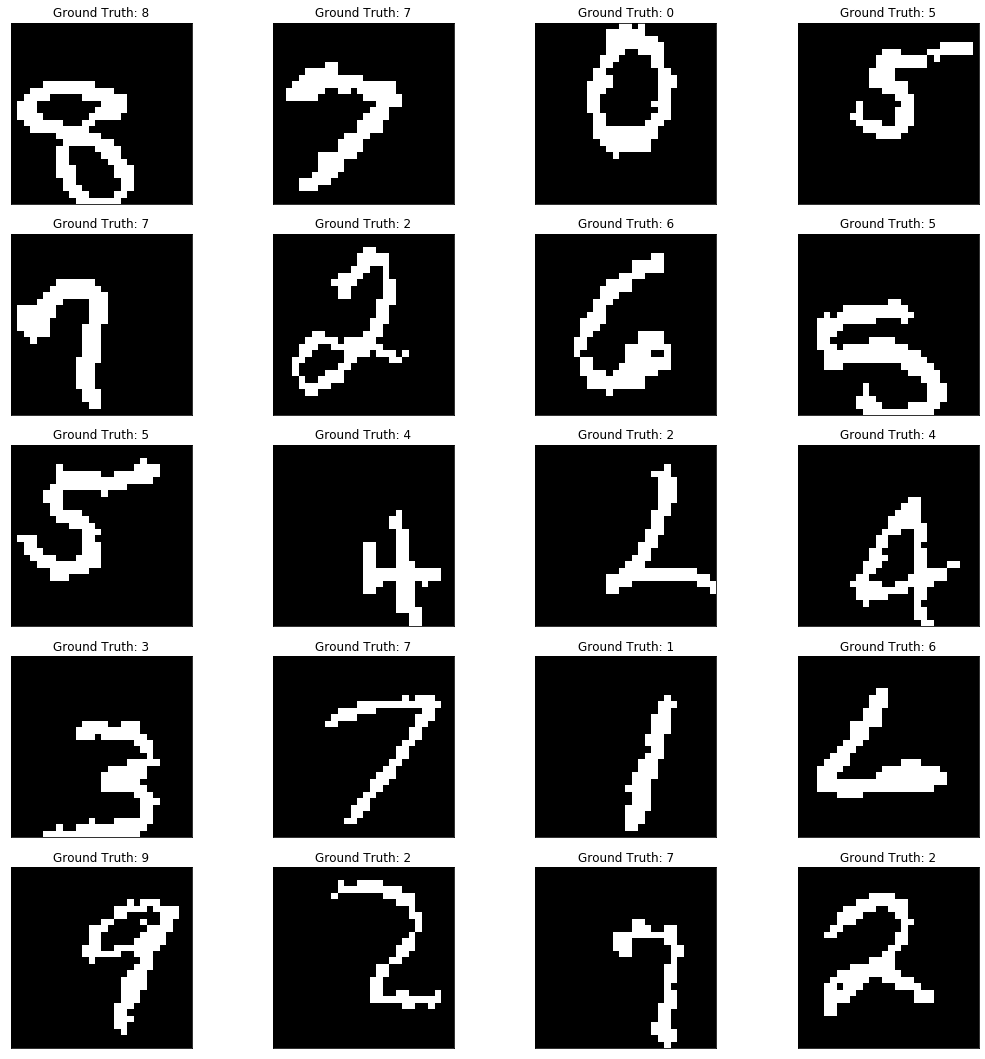

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(15,15))
num_examples_rows = 5
num_examples_cols = 4
for r in range(num_examples_rows):
    for c in range(num_examples_cols):
        idx = r*num_examples_cols + c + 1
        plt.subplot(num_examples_rows, num_examples_cols, idx)
        plt.tight_layout()
        plt.imshow(example_data[idx][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[idx]))
        plt.xticks([])
        plt.yticks([])

## Model

Create a neural net with PyTorch's classes. After training, we will pull the weights from each layer and compare the output of the PyTorch model with a "bare-metal" Numpy module.

In [7]:
def build_simple_neural_net(num_hidden_layers=2, hidden_layer_width=100, input_size=28*28, output_size=10):
    modules = []
    
    for hidden_layer in range(num_hidden_layers):
        # Hidden layer
        if hidden_layer == 0: # first layer
            modules.append(nn.Linear(input_size, hidden_layer_width))
        else:
            modules.append(nn.Linear(hidden_layer_width, hidden_layer_width))
        # ReLU
        modules.append(nn.ReLU())
        
    # Output layer
    modules.append(nn.Linear(hidden_layer_width, output_size))
    
    # Softmax
    modules.append(nn.LogSoftmax(dim=1))
    
    return nn.Sequential(*modules)

## Training
Create a model and train it on the preprocessed data.

Function to run 1 training epoch over all training data in the loader:

In [8]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    cumulative_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1) # flatten image into 1D vector
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
    return cumulative_loss / len(train_loader)

Function to run an accuracy test over all data in the loader:

In [9]:
def test(model, test_loader):
    model.eval()
    correct_count, all_count = 0, 0
    for images, labels in test_loader:
        for i in range(len(labels)):
            image = images[i].view(1, 784)
            with torch.no_grad():
                log_probs = model(image)
            probs_tnsr = torch.exp(log_probs)
            probabilities = list(probs_tnsr.numpy()[0])
            pred_label = probabilities.index(max(probabilities))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1
    acc = 100 * correct_count / all_count # model accuracy
    return acc, correct_count, all_count

Construct a model, then train. The model will be saved to a file.

In [10]:
model = build_simple_neural_net(num_hidden_layers=2, hidden_layer_width=200)
num_epochs = 50
model_path = "./data/model.pt"
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

# NOTE: the model instance from above will be overwritten if a model exists at the provided path
try:
    model = torch.load(model_path)
except:
    print("Did not load a model.")

training_results = []
testing_results = []
for epoch in range(1, num_epochs+1):
    print("Epoch %d..." % epoch)
    avg_loss = train(model, optimizer, criterion, train_loader)
    percent_correct_train, num_correct_train, count_train = test(model, train_loader)
    percent_correct_test, num_correct_test, count_test  = test(model, test_loader)
    training_results.append(percent_correct_train)
    testing_results.append(percent_correct_test)
    print("\tTraining Loss: %.4f" % avg_loss)
    print("\tTraining Error: %.2f%% (%d/%d)" % (percent_correct_train, num_correct_train, count_train))
    print("\tTesting Error : %.2f%% (%d/%d)" % (percent_correct_test, num_correct_test, count_test))
    torch.save(model, model_path)

Did not load a model.
Epoch 1...
	Training Loss: 1.7635
	Training Error: 59.75% (35852/60000)
	Testing Error : 60.49% (6049/10000)
Epoch 2...


/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject

	Training Loss: 1.0407
	Training Error: 72.43% (43460/60000)
	Testing Error : 73.37% (7337/10000)
Epoch 3...
	Training Loss: 0.7950
	Training Error: 78.31% (46987/60000)
	Testing Error : 79.39% (7939/10000)
Epoch 4...
	Training Loss: 0.6651
	Training Error: 81.71% (49025/60000)
	Testing Error : 82.43% (8243/10000)
Epoch 5...
	Training Loss: 0.5773
	Training Error: 83.92% (50350/60000)
	Testing Error : 84.18% (8418/10000)
Epoch 6...
	Training Loss: 0.5150
	Training Error: 85.47% (51283/60000)
	Testing Error : 86.59% (8659/10000)
Epoch 7...
	Training Loss: 0.4741
	Training Error: 86.38% (51827/60000)
	Testing Error : 86.52% (8652/10000)
Epoch 8...
	Training Loss: 0.4488
	Training Error: 87.17% (52305/60000)
	Testing Error : 87.34% (8734/10000)
Epoch 9...
	Training Loss: 0.4190
	Training Error: 88.03% (52818/60000)
	Testing Error : 88.78% (8878/10000)
Epoch 10...
	Training Loss: 0.3984
	Training Error: 88.45% (53070/60000)
	Testing Error : 89.12% (8912/10000)
Epoch 11...
	Training Loss: 0

Plot the training/testing results across epochs:

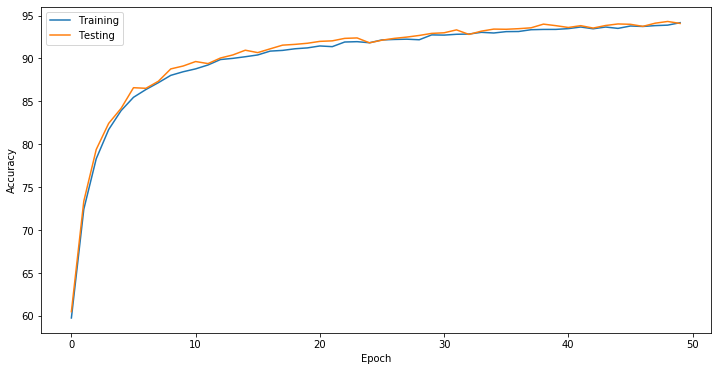

In [11]:
fig = plt.figure(figsize=(12,6))
plt.plot(training_results, label="Training")
plt.plot(testing_results, label="Testing")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#### Below are some model and transform configurations and their accuracy after training:

##### 2-layer, 128 and 64 widths, 90% accuracy:
    torchvision.transforms.RandomAffine((-15,15), translate=(.2,.2)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)), # mean and std. dev. of MNIST dataset
    torchvision.transforms.Lambda(lambda x: preprocess_data(x, noisy=True))

##### 2-layer, 200 widths, 94% accuracy:
    torchvision.transforms.RandomAffine((-15,15), translate=(.2,.2)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)), # mean and std. dev. of MNIST dataset
    torchvision.transforms.Lambda(lambda x: preprocess_data(x, noisy=True))

## Numpy Evaluation
Extract the trained weights from the PyTorch model, format them as Numpy arrays, and validate the outputs of Numpy operations with the PyTorch model.

Extract weights as Numpy matrices from PyTorch model.

In [46]:
model_path = "./data/model.pt"
model = torch.load(model_path)


# Hidden layers' weights/biases
hidden_layer_weights = []
hidden_layer_biases = []
num_hidden_layers = 0 # count of hidden layers
# Output layer's weight/bias
output_layer_weight = None
output_layer_bias = None


# Parse PyTorch model
num_modules = len(model)
i = 0
while i < num_modules-1:
    module = model[i]; i += 1
    next_module = model[i]; i += 1
    
    # Expect a linear module first
    assert isinstance(module, nn.modules.linear.Linear), "Expected Linear module"
    
    # Make sure following module is ReLU or LogSoftmax
    assert isinstance(next_module, nn.modules.activation.LogSoftmax) or \
            isinstance(next_module, nn.modules.activation.ReLU), "Expected ReLU or LogSoftmax module"
    
    # Make sure LogSoftmax is only at the end
    if isinstance(next_module, nn.modules.activation.LogSoftmax):
        assert i >= num_modules-1
    
    # Make sure last model is LogSoftmax
    if i == num_modules-1:
        assert isinstance(next_module, nn.modules.activation.LogSoftmax), "LogSoftmax should be last module."
    
    # Parse Linear module
    weight = module.weight.detach().numpy()
    bias = module.bias.detach().numpy()
    if isinstance(next_module, nn.modules.activation.ReLU): # is hidden layer
        hidden_layer_weights.append(weight)
        hidden_layer_biases.append(bias)
        num_hidden_layers += 1
    else: # is output layer
        output_layer_weight = weight
        output_layer_bias = bias

Evaluate neural net with Numpy functions and compare to output of PyTorch neural net model.

In [47]:
def evaluate_numpy_nn(x):
    # Hidden layers
    for h in range(num_hidden_layers):
        x = np.matmul(hidden_layer_weights[h], x) + hidden_layer_biases[h] # H: W*x + b
        x = np.maximum(x, 0) # ReLU
    # Output layer
    x = np.matmul(output_layer_weight, x) + output_layer_bias # Output: W*x + b
    # Log softmax
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [79]:
num_tests = 100
for i in range(num_tests):
    fake_image_np = 10*np.random.rand(784)
    fake_image_tnsr = torch.from_numpy(fake_image_np).float().view(1, 784)
    pytorch_output = model(fake_image_tnsr).detach().numpy().squeeze()
    numpy_output = evaluate_numpy_nn(fake_image_np)
    np.testing.assert_allclose(pytorch_output, numpy_output, rtol=1e-03, equal_nan=False)
print("All %d tests passed!" % num_tests)

All 100 tests passed!


## Test Camera Images
Test the model on real images taken from the camera.

There are 10 images, one for each digit 0...9.

Preprocessing, from JPG image to 28x28 downsampled, thresholded image:

In [218]:
def preprocess_camera_image(jpg_path, black_threshold=.15, crop_margin=0.85):
    # Open with PIL
    with Image.open(jpg_path) as img_PIL:
        # Crop (to square, remove timestamp)
        width, height = img_PIL.size 
        target_size = crop_margin * height
        leftright_margin = (width - target_size) / 2
        topbottom_margin = (height - target_size) / 2
        area = (leftright_margin, topbottom_margin, width-leftright_margin, \
                       height-topbottom_margin) # rescale to square and remove time stamp
        img_PIL = img_PIL.crop(area)
        # Convert to Numpy
        img = np.asarray(img_PIL)
    # Grayscale (by averaging channels)
    img_gray = np.mean(img, axis=2)
    # Treshold
    minn = np.min(img_gray)
    maxx = np.max(img_gray)
    rng = maxx-minn
    thresh = black_threshold * rng + minn
    img_thresh = img_gray < thresh
    # Downsample (using max)
    img_small = block_reduce(img_thresh, block_size=(28, 28), func=np.max)[:28,:28]
    return img_small

Let's read in the images, preprocess them, and take a look:

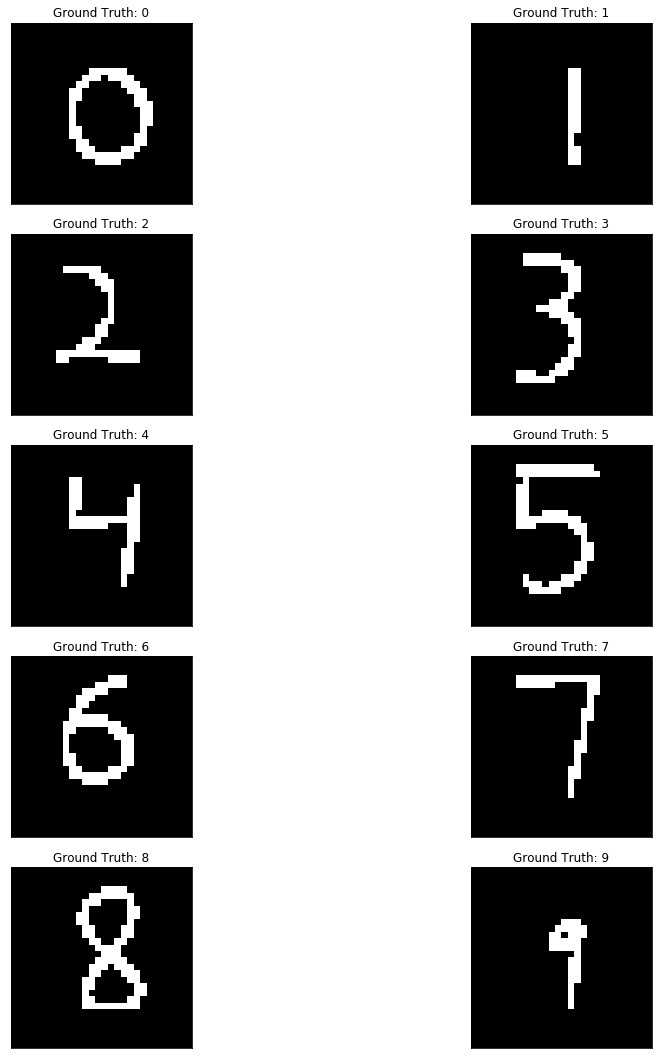

In [219]:
real_images = []
fig = plt.figure(figsize=(15,15))
num_examples_rows = 5
num_examples_cols = 2
for r in range(num_examples_rows):
    for c in range(num_examples_cols):
        # Get image
        digit = r*num_examples_cols + c
        jpg_path = "./data/real_images/%d.JPG" % digit
        image = preprocess_camera_image(jpg_path)
        real_images.append(image)
        # Plot
        plt_idx = r*num_examples_cols + c + 1
        plt.subplot(num_examples_rows, num_examples_cols, plt_idx)
        plt.tight_layout()
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(digit))
        plt.xticks([])
        plt.yticks([])

Now, let's see if our model correctly predicts the digits:

In [225]:
for digit in range(10):
    inpt = real_images[digit].flatten()
    probabilities = evaluate_numpy_nn(inpt)
    prediction = np.argmax(probabilities)
    if prediction == digit:
        print("Succeeded predicting digit %d" % digit)
    else:
        print("FAILED    predicting digit %d:  %d" % (digit, prediction))

Succeeded predicting digit 0
Succeeded predicting digit 1
Succeeded predicting digit 2
Succeeded predicting digit 3
Succeeded predicting digit 4
Succeeded predicting digit 5
FAILED    predicting digit 6:  5
Succeeded predicting digit 7
Succeeded predicting digit 8
FAILED    predicting digit 9:  4
